In [1]:
import pandas as pd
import numpy as np
from sklearn.calibration import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import randint

In [2]:
df = pd.read_csv("adultcensusincome.csv", encoding='ISO-8859-1')
print(df.head(2))
print(df.shape)

   age workclass  fnlwgt education  education.num marital.status  \
0   90         ?   77053   HS-grad              9        Widowed   
1   82   Private  132870   HS-grad              9        Widowed   

        occupation   relationship   race     sex  capital.gain  capital.loss  \
0                ?  Not-in-family  White  Female             0          4356   
1  Exec-managerial  Not-in-family  White  Female             0          4356   

   hours.per.week native.country income  
0              40  United-States  <=50K  
1              18  United-States  <=50K  
(32561, 15)


In [3]:
# Identify missing values [1]
missing_values = df.isnull().sum()
print("\nMissing Values:\n", missing_values)


Missing Values:
 age               0
workclass         0
fnlwgt            0
education         0
education.num     0
marital.status    0
occupation        0
relationship      0
race              0
sex               0
capital.gain      0
capital.loss      0
hours.per.week    0
native.country    0
income            0
dtype: int64


In [4]:
# Check for duplicate records and remove them [10]
duplicate_rows = df.duplicated().sum()
print(f"\nNumber of duplicate rows: {duplicate_rows}")
df.drop_duplicates(inplace=True)
print("Duplicate rows removed.")


Number of duplicate rows: 24
Duplicate rows removed.


In [5]:
#Check for ? in all columns
for col in df.columns:
    if df[col].dtype == 'object':
        num_question_marks = (df[col] == '?').sum()
        print(f"Column '{col}' has {num_question_marks} '?' values.")

Column 'workclass' has 1836 '?' values.
Column 'education' has 0 '?' values.
Column 'marital.status' has 0 '?' values.
Column 'occupation' has 1843 '?' values.
Column 'relationship' has 0 '?' values.
Column 'race' has 0 '?' values.
Column 'sex' has 0 '?' values.
Column 'native.country' has 582 '?' values.
Column 'income' has 0 '?' values.


In [6]:
#Removing columns with ? in them
df = df.replace('?', np.nan)
df.dropna(inplace=True)
print("Rows with '?' removed.")
df.info()
print(df.info())

Rows with '?' removed.
<class 'pandas.core.frame.DataFrame'>
Index: 30139 entries, 1 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             30139 non-null  int64 
 1   workclass       30139 non-null  object
 2   fnlwgt          30139 non-null  int64 
 3   education       30139 non-null  object
 4   education.num   30139 non-null  int64 
 5   marital.status  30139 non-null  object
 6   occupation      30139 non-null  object
 7   relationship    30139 non-null  object
 8   race            30139 non-null  object
 9   sex             30139 non-null  object
 10  capital.gain    30139 non-null  int64 
 11  capital.loss    30139 non-null  int64 
 12  hours.per.week  30139 non-null  int64 
 13  native.country  30139 non-null  object
 14  income          30139 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB
<class 'pandas.core.frame.DataFrame'>
Index: 30139 entries, 1 to 32560
Data

In [7]:
# Assume 'target' is the label column in your dataset
class_distribution = df['income'].value_counts()
print(class_distribution)

income
<=50K    22633
>50K      7506
Name: count, dtype: int64


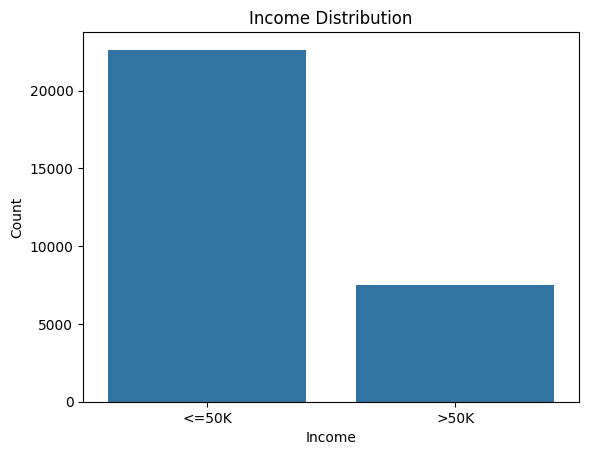

In [8]:
#barplot for income
sns.countplot(x='income', data=df)
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Count')
plt.show()

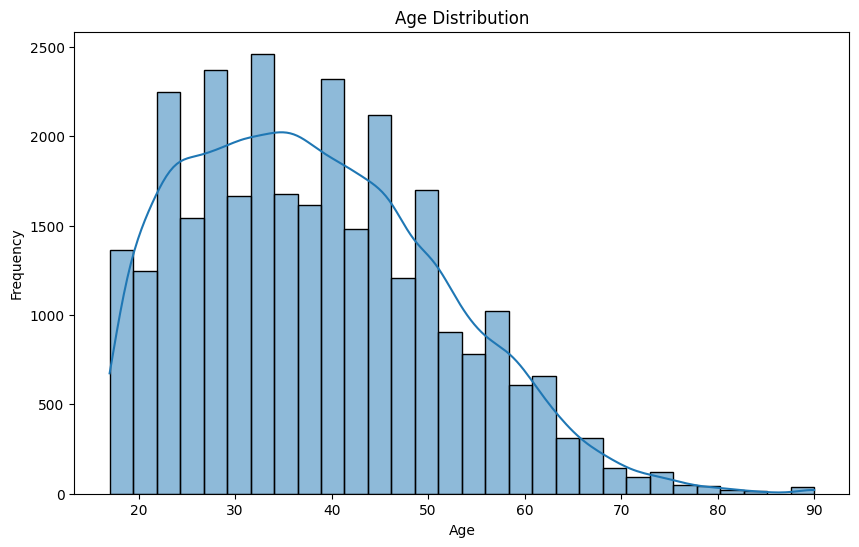

In [9]:
#Distribution of age
plt.figure(figsize=(10, 6))
sns.histplot(df['age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()

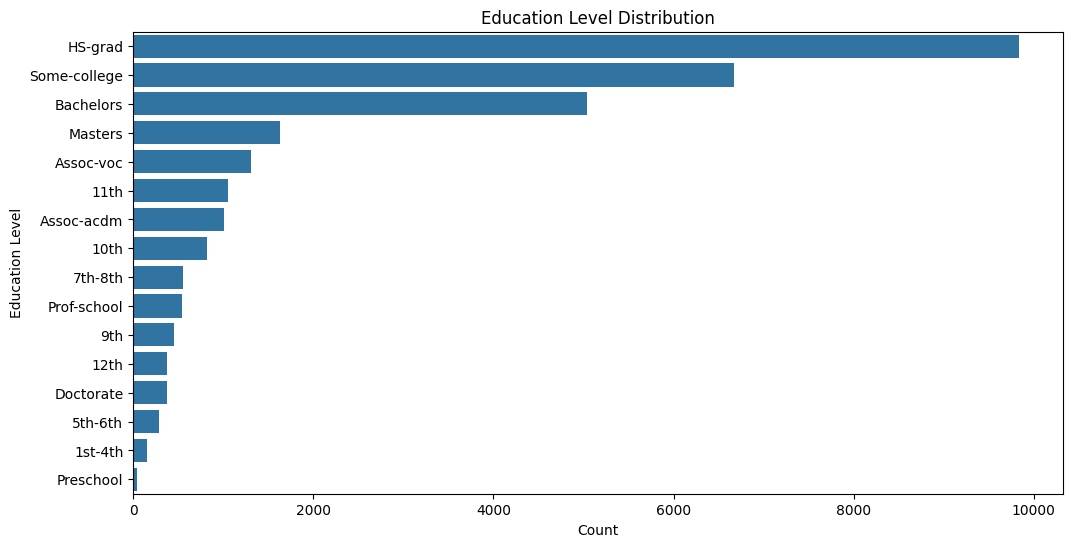

In [10]:
#Barplot for education
plt.figure(figsize=(12, 6))
sns.countplot(y='education', data=df, order=df['education'].value_counts().index)
plt.title('Education Level Distribution')
plt.xlabel('Count')
plt.ylabel('Education Level')
plt.show()

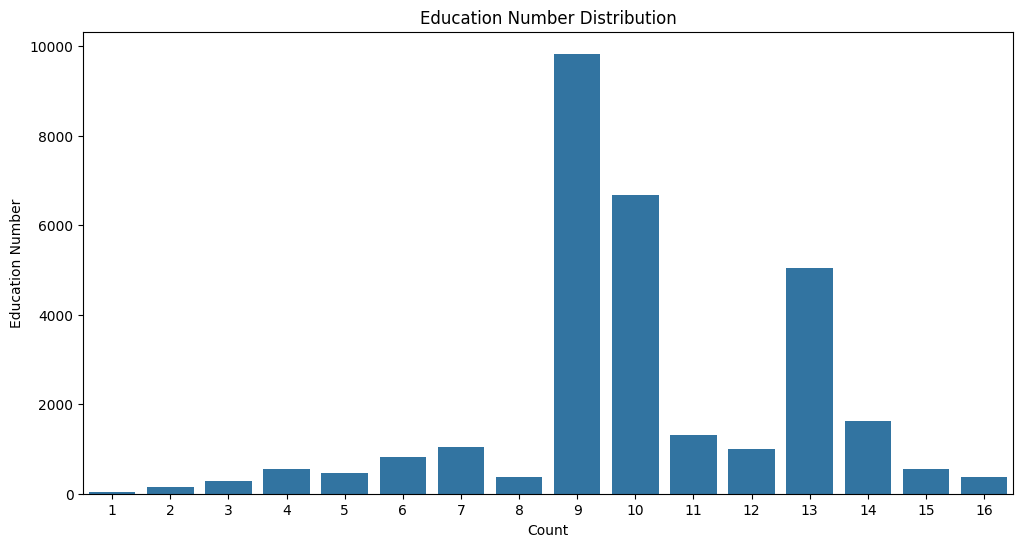

In [11]:
#Barplot for year of education
plt.figure(figsize=(12, 6))
sns.countplot(x='education.num', data=df)
plt.title('Education Number Distribution')
plt.xlabel('Count')
plt.ylabel('Education Number')
plt.show()

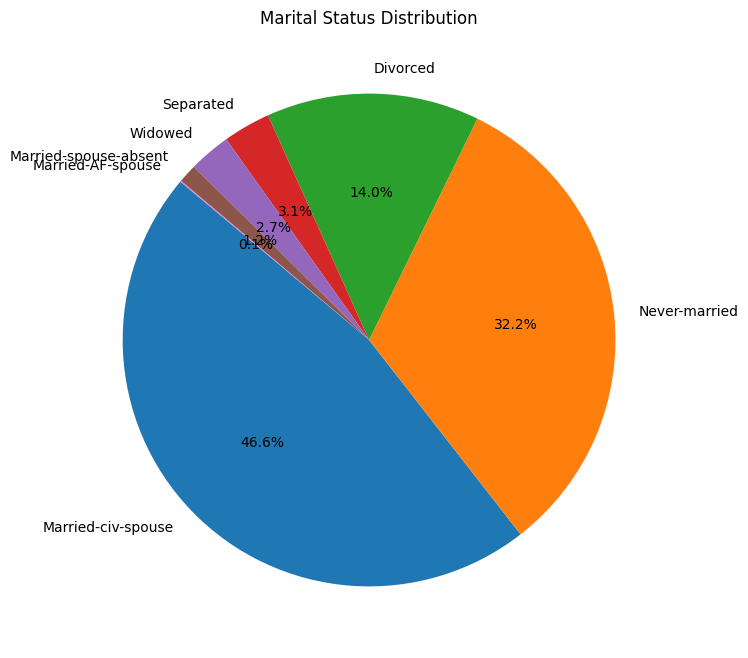

In [12]:
#Piechart for marital status
plt.figure(figsize=(8, 8))
df['marital.status'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140)
plt.title('Marital Status Distribution')
plt.ylabel('')  # Hide the y-label
plt.show()

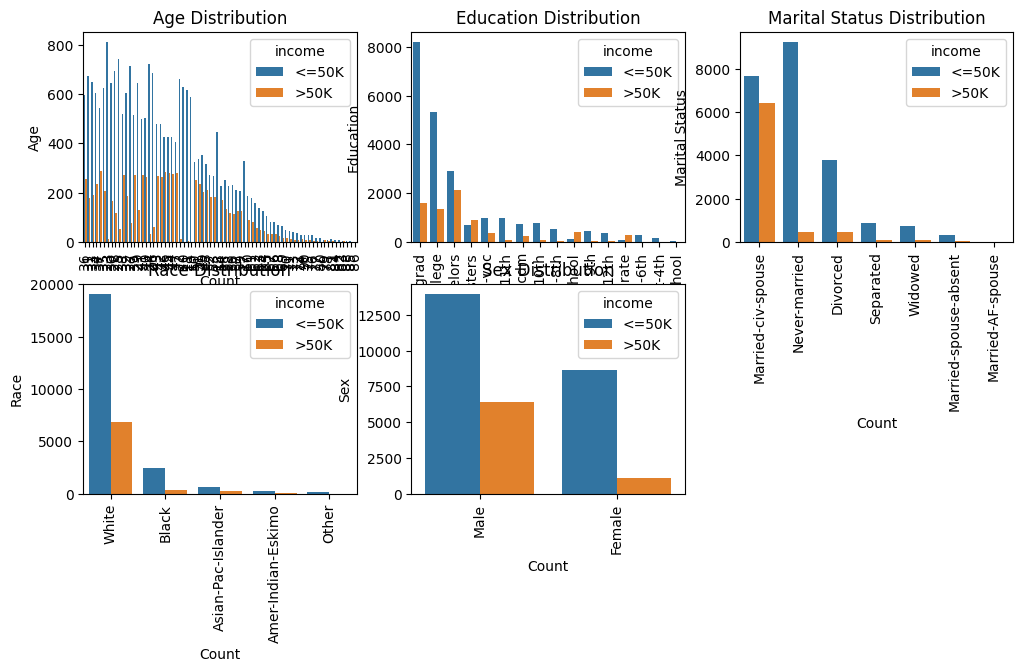

In [13]:
#Count plot for age, education, marital status, race, sex
plt.figure(figsize=(12, 6))
for i, col in enumerate(['age', 'education', 'marital.status', 'race', 'sex'], start=1):
    plt.subplot(2, 3, i)
    sns.countplot(x=col, data=df, hue="income", order=df[col].value_counts().index)
    plt.xticks(rotation=90)
    plt.title(f'{col.replace(".", " ").title()} Distribution')
    plt.xlabel('Count')
    plt.ylabel(col.replace(".", " ").title())
plt.show()
# The most correlated features with the target variable was  number of education years

In [14]:
#Task 2: Data Preprocessing
# Label encode categorical variables
categorical_columns = ['workclass', 'education', 'marital.status', 'occupation',
                       'relationship', 'race', 'sex', 'native.country', 'income']
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

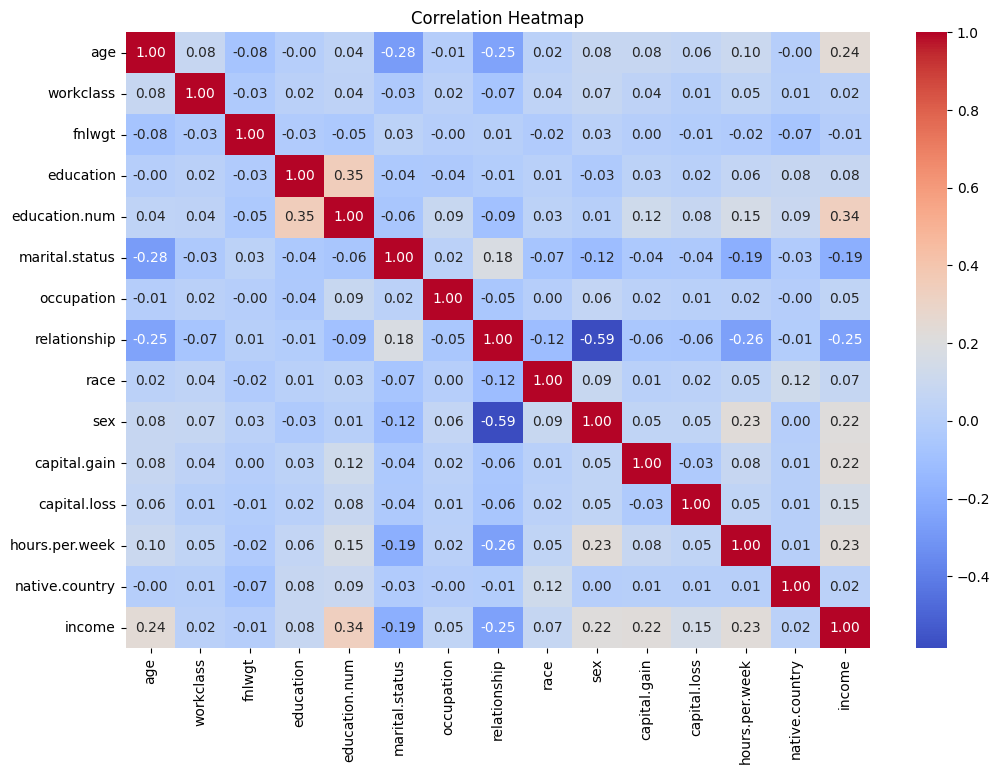

In [15]:
# Heatmap for correlation
plt.figure(figsize=(12, 8))
correlation_matrix = df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [16]:
X = df.drop(columns=['income'])
Y = df['income']

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [18]:
smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(X_scaled, Y)
X_train, X_test, Y_train, Y_test = train_test_split(X_resampled, Y_resampled, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 36212 samples
Testing set size: 9054 samples


Logistic Regression F1 Score: 0.7689

 Logistic Regression Performance 
Accuracy: 0.7682
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.76      0.77      4542
           1       0.76      0.77      0.77      4512

    accuracy                           0.77      9054
   macro avg       0.77      0.77      0.77      9054
weighted avg       0.77      0.77      0.77      9054

KNN F1 Score: 0.8615

 KNN Performance 
Accuracy: 0.8524
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.78      0.84      4542
           1       0.81      0.92      0.86      4512

    accuracy                           0.85      9054
   macro avg       0.86      0.85      0.85      9054
weighted avg       0.86      0.85      0.85      9054

Naïve Bayes F1 Score: 0.6255

 Naïve Bayes Performance 
Accuracy: 0.7070
Classification Report:
               precision    recall  f1-score   support



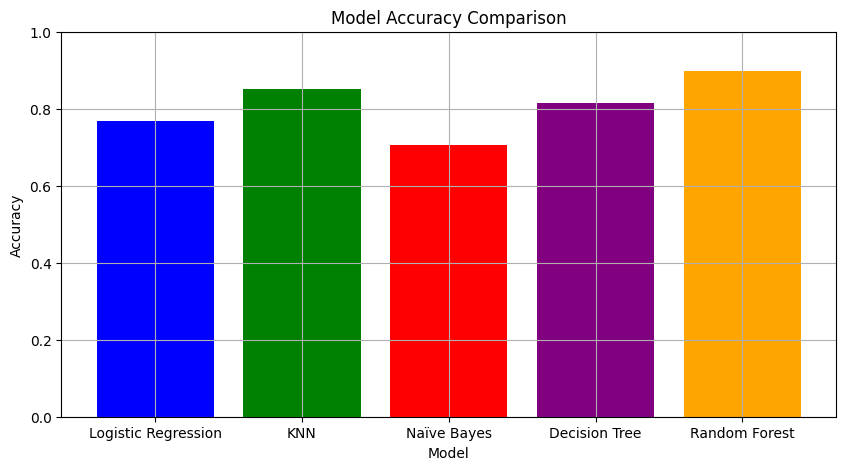

In [19]:
#Task 3: Model Training and Evaluation
# Train a logistic regression model
# Forest Classifier
models = {
    "Logistic Regression": LogisticRegression(),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    # "SVM": SVC(kernel='rbf', probability=True),
    "Naïve Bayes": GaussianNB(),
    "Decision Tree": DecisionTreeClassifier(max_depth=5),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}
results = {}
for name, model in models.items():
    model.fit(X_train, Y_train)  # Train model
    y_pred = model.predict(X_test)  # Predict on test set
    accuracy = accuracy_score(Y_test, y_pred)  # Calculate accuracy
    f1 = f1_score(Y_test, y_pred)
    results[name] = accuracy  # Store accuracy
    print(f"{name} F1 Score: {f1:.4f}")
    print(f"\n {name} Performance ")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", classification_report(Y_test, y_pred))
plt.figure(figsize=(10, 5))
plt.bar(results.keys(), results.values(), color=['blue', 'green', 'red', 'purple', 'orange', 'black'])
plt.title("Model Accuracy Comparison")
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.show()

Confusion Matrix:
[[4040  502]
 [ 422 4090]]


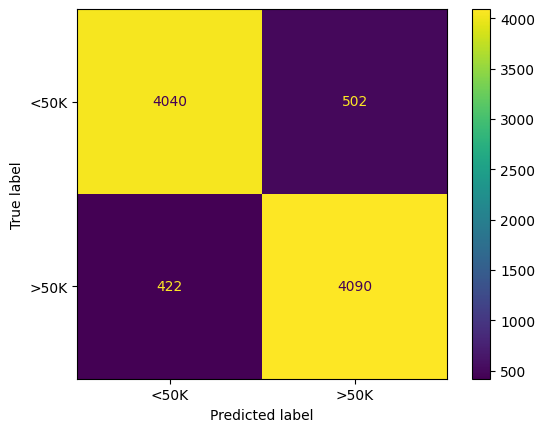

In [20]:
# Print confusion matrix
conf_matrix = confusion_matrix(Y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)
cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels = ["<50K", ">50K"])

# display matrix
cm_display.plot()
plt.show()

In [21]:
# Perform Grid Search CV for hyperparameter tuning
param_grid = { 'n_estimators': [100, 200, 300], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['auto', 'sqrt'] }
grid_search = GridSearchCV(model, param_grid, scoring="f1", cv=5, n_jobs=-1)
grid_search.fit(X_train, Y_train)
# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best F1 Score:", best_score)

/Users/cullen/Documents/Python-Projects/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/cullen/Documents/Python-Projects/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
405 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
306 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/cullen/Documents/Python-Projects/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estima

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best F1 Score: 0.8955556580534786


In [22]:
#Hyperparameter tuning for Random Forest
best_tuned_model = model.set_params(**best_params)
best_tuned_model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(Y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      4542
           1       0.89      0.91      0.90      4512

    accuracy                           0.90      9054
   macro avg       0.90      0.90      0.90      9054
weighted avg       0.90      0.90      0.90      9054



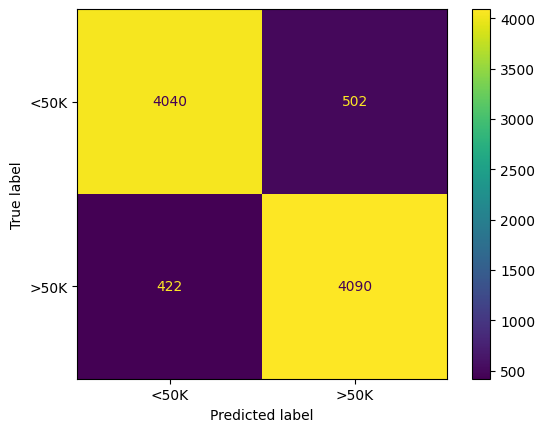

In [23]:
# display matrix
cm_display.plot()
plt.show()

In [24]:
# Perform Grid Search CV for hyperparameter tuning
param_grid = { 'n_estimators': [100, 200, 300], 'max_depth': [10, 20, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'max_features': ['auto', 'sqrt'] }
grid_search = GridSearchCV(model, param_grid, scoring="f1", cv=5, n_jobs=-1)
grid_search.fit(X_train, Y_train)
# Best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best F1 Score:", best_score)
#Hyperparameter tuning for Random Forest
best_tuned_model = model.set_params(**best_params)
best_tuned_model.fit(X_train, Y_train)
y_pred = model.predict(X_test)
print("Classification Report:\n", classification_report(Y_test, y_pred))

/Users/cullen/Documents/Python-Projects/.venv/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/cullen/Documents/Python-Projects/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
405 fits failed out of a total of 810.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
393 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/cullen/Documents/Python-Projects/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estima

Best Parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best F1 Score: 0.8957137523235603
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      4542
           1       0.89      0.91      0.90      4512

    accuracy                           0.90      9054
   macro avg       0.90      0.90      0.90      9054
weighted avg       0.90      0.90      0.90      9054

